In [40]:
from gurobipy import *
from itertools import combinations
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def ri(low,high,m_one=0.):
    p = np.random.uniform(0,1)
    if(m_one < p):
        return np.random.randint(low,high)
    return -1

In [3]:
opt_mod = Model(name = "vessel swap body routing")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-29


In [4]:
speed                  = 333
coupling_time          = 15
decoupling_time        = 15
body_capacity          = 50
max_bodies             = 3
n_nodes                = 4
n_vessels              = 2
n_bodies               = 3
n_requests             = 3
unscheduled_cost_coeff = 10000
service_time           = 2

In [5]:
distances = np.array([[0,64100,64700,59000,68800],
                     [64100,0,10900,6200,6800],
                     [64700,10900,0,5800,4100],
                     [59000,6200,5800,0,9800],
                     [68800,6800,4100,9800,0]
                     ])

In [6]:
Nodes = tuplelist()
for i in range(n_nodes):
    Nodes.append((i,1))

Vessels = tuplelist()
for i in range(n_vessels):
    Vessels.append((i,ri(0,n_nodes),0))

Bodies = tuplelist()
for i in range(n_bodies):
    vessel = ri(0,n_vessels)
    Bodies.append((i,vessel,Vessels[vessel][1]))

Requests = tuplelist()
for i in range(n_requests):
    at_body_id = ri(0,n_bodies,.7)
    pick_id    = -1 if at_body_id != -1 else ri(0,n_nodes)
    pick_from  = -1 if at_body_id != -1 else ri(0,21600)
    pick_to    = -1 if at_body_id != -1 else pick_from + ri(0,5760) 
    deliv_id   = ri(0,n_nodes)
    while(deliv_id == pick_id):
        deliv_id = ri(0,n_nodes)
    deliv_from = ri(0,21600) if at_body_id != -1 else pick_to + ri(7200,14400)
    deliv_to   = deliv_from + ri(0,5760) if at_body_id != -1 else deliv_from + ri(0,5760)
    num_containters = ri(1,body_capacity/2)
    Requests.append((i,pick_id,pick_from,pick_to,deliv_id,deliv_from,deliv_to,num_containters,at_body_id))
Requests

<gurobi.tuplelist (3 tuples, 9 values each):
 ( 0 , 2  , 5864 , 11193 , 0 , 24982 , 29881 , 6  , -1 )
 ( 1 , -1 , -1   , -1    , 3 , 12804 , 17122 , 5  , 2  )
 ( 2 , 1  , 4726 , 6592  , 0 , 17845 , 18158 , 18 , -1 )
>

In [7]:
nodes_requests  = {}
nodes_locations = {}
Pickup_nodes        = []
Pickup_nodes_copy   = []
Delivery_nodes      = []
Delivery_nodes_copy = []
for i in range(n_requests):
    if(Requests[i][1] != -1):
        label = "P_" + str(i)
        Pickup_nodes.append(label)
        nodes_requests[label] = i
        nodes_locations[label] = Requests[i][1]
        
        label_copy = "P'_" + str(i + n_requests)
        Pickup_nodes_copy.append(label_copy)
        nodes_requests[label_copy] = i
        nodes_locations[label_copy] = Requests[i][1]
    
    if(Requests[i][4] != -1):
        label = "D_" + str(i + 2*n_requests)
        Delivery_nodes.append(label)
        nodes_requests[label] = i
        nodes_locations[label] = Requests[i][4]
        
        label_copy = "D'_" + str(i + 3*n_requests)
        Delivery_nodes_copy.append(label_copy)
        nodes_requests[label_copy] = i
        nodes_locations[label_copy] = Requests[i][4]
        
I = Pickup_nodes + Pickup_nodes_copy + Delivery_nodes + Delivery_nodes_copy

J_0 = []
for i in range(n_vessels):
    label = "o_v_" + str(i)
    J_0.append(label)
    nodes_locations[label] = Vessels[i][1]
for i in range(n_bodies):
    label = "o_b_" + str(i)
    J_0.append(label)
    nodes_locations[label] = Bodies[i][2]
    
Dummy = ["sink"]
nodes_locations["sink"] = -1

N = J_0 + I + Dummy
print(N)
print(nodes_requests)
print(nodes_locations)

['o_v_0', 'o_v_1', 'o_b_0', 'o_b_1', 'o_b_2', 'P_0', 'P_2', "P'_3", "P'_5", 'D_6', 'D_7', 'D_8', "D'_9", "D'_10", "D'_11", 'sink']
{'P_0': 0, "P'_3": 0, 'D_6': 0, "D'_9": 0, 'D_7': 1, "D'_10": 1, 'P_2': 2, "P'_5": 2, 'D_8': 2, "D'_11": 2}
{'P_0': 2, "P'_3": 2, 'D_6': 0, "D'_9": 0, 'D_7': 3, "D'_10": 3, 'P_2': 1, "P'_5": 1, 'D_8': 0, "D'_11": 0, 'o_v_0': 1, 'o_v_1': 1, 'o_b_0': 1, 'o_b_1': 1, 'o_b_2': 1, 'sink': -1}


In [8]:
A_1 = tuplelist()
A_2 = tuplelist()
A_3 = tuplelist()
A_4 = tuplelist()
A_5 = tuplelist()
A_sink = tuplelist()
A_D = tuplelist()
A = tuplelist()

# A_1
for o in J_0:
    for n in N:
        if(o == n):
            continue
        A_1.append((o,n))
###################################################################
# A_2
for p,p_copy in zip(Pickup_nodes,Pickup_nodes_copy):
    A_2.append((p,p_copy))
for p in Pickup_nodes:
    r = nodes_requests[p]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_2.append((p,n))
###################################################################
# A_3
for p_copy,d in zip(Pickup_nodes_copy,Delivery_nodes):
    A_3.append((p_copy,d))
for p_copy in Pickup_nodes_copy:
    r = nodes_requests[p_copy]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_3.append((p_copy,n))
###################################################################
# A_4
for d,d_copy in zip(Delivery_nodes,Delivery_nodes_copy):
    A_4.append((d,d_copy))
for d in Delivery_nodes:
    r = nodes_requests[d]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_4.append((d,n))
###################################################################
# A_5
for d_copy in Delivery_nodes_copy:
    r = nodes_requests[d_copy]
    for n in N:
        if(n[0] == 'P' or n[0] == 'D'):
            if(nodes_requests[n] == r):
                continue
        A_5.append((d_copy,n))
###################################################################
# A_sink
for n in J_0 + I:
    A_sink.append((n,Dummy[0]))

A = A_1 + A_2 + A_3 + A_4 + A_5 #+ A_sink

# A_D
for i,j in A:
    if(nodes_locations[i] == nodes_locations[j]):
        A_D.append((i,j))
A_D += A_sink

In [9]:
travel_time = {}
for dep,arr in A:
    time = distances[nodes_locations[dep],nodes_locations[arr]] / speed if nodes_locations[arr] != -1 else 0
    
    if(dep in I and arr in I and nodes_requests[dep] == nodes_requests[arr]):
        service_time = coupling_time if A_1.select(dep,arr) else decoupling_time
        r = nodes_requests[dep]
        time = service_time * Requests[r][7]
       # if(dep[:2] == "P_" and arr[:3] == "P'_"):
       #     r = nodes_requests[dep]
       #     time = coupling_time * Requests[r][7]
       # if(dep[:2] == "D_" and arr[:3] == "D'_"):
       #     r = nodes_requests[dep]
       #     time = decoupling_time * Requests[r][7]
            
    travel_time[(dep,arr)] = time

In [10]:
z_v      = []
beta_b   = []
omega_bv = []
x_br     = []
delta_b  = []
gamma_r  = []
tau_a_v  = []
tau_d_v  = []
tau_a_b  = []
tau_d_b  = []
y_v      = []
phi_b    = []

for v in range(n_vessels):
    z_v.append({})
    for arc in A:
        z_v[v][arc] = opt_mod.addVar(name = "z_" + str(v) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for b in range(n_bodies):
    beta_b.append({})
    for arc in A:
        beta_b[b][arc] = opt_mod.addVar(name = "beta_" + str(b) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for v in range(n_vessels):
    omega_bv.append([])
    for b in range(n_bodies):
        omega_bv[v].append({})
        for arc in A:
            omega_bv[v][b][arc] = opt_mod.addVar(name = "omega_" + str(b) + "_" + str(v) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for r in range(n_requests):
    x_br.append([])
    for b in range(n_bodies):
        x_br[r].append({})
        for arc in A:
            x_br[r][b][arc] = opt_mod.addVar(name = "x_" + str(b) + "_" + str(r) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for b in range(n_bodies):
    delta_b.append({})
    for arc in A:
        delta_b[b][arc] = opt_mod.addVar(name = "delta_" + str(b) + "_(" + arc[0] + "," + arc[1] + ")", vtype = GRB.BINARY)

for r in range(n_requests):
    gamma_r.append(opt_mod.addVar(name = "gamma_" + str(r), vtype = GRB.BINARY))

for v in range(n_vessels):
    tau_a_v.append({})
    for n in N:
        tau_a_v[v][n] = opt_mod.addVar(name = "tau_a_" + str(v) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for v in range(n_vessels):
    tau_d_v.append({})
    for n in N:
        tau_d_v[v][n] = opt_mod.addVar(name = "tau_d_" + str(v) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for b in range(n_bodies):
    tau_a_b.append({})
    for n in N:
        tau_a_b[b][n] = opt_mod.addVar(name = "tau_B_a_" + str(b) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for b in range(n_bodies):
    tau_d_b.append({})
    for n in N:
        tau_d_b[b][n] = opt_mod.addVar(name = "tau_B_d_" + str(b) + "_" + n, vtype = GRB.CONTINUOUS, lb = 0)

for v in range(n_vessels):
    y_v.append({})
    for i in N:
        for j in N:
            if(i == j):
                continue
            y_v[v][(i,j)] = opt_mod.addVar(name = "y_" + str(v) + "_(" + i + "," + j + ")", vtype = GRB.BINARY)

for b in range(n_bodies):
    phi_b.append({})
    for i in N:
        for j in N:
            if(i == j):
                continue
            phi_b[b][(i,j)] = opt_mod.addVar(name = "phi_" + str(b) + "_(" + i + "," + j + ")", vtype = GRB.BINARY)

opt_mod.update()

In [11]:
obj_fn = quicksum(quicksum(travel_time[a]*z_v[v][a] for a in A) for v in range(n_vessels)) + quicksum(unscheduled_cost_coeff * (1 - gamma_r[r]) for r in range(n_requests))
opt_mod.setObjective(obj_fn,GRB.MINIMIZE)

In [12]:
# Routing for vessels and bodies costraints

c_2 = []
c_3 = []
c_4 = {}

for v in range(n_vessels):
    c_2.append(
        opt_mod.addConstr(
            quicksum(
                z_v[v][arc] for arc in A.select(J_0[v],"*")) == 1))
    
for v in range(n_vessels):
    c_3.append(
        opt_mod.addConstr(
            quicksum(
                z_v[v][arc] for arc in A_sink) == 1))
#
#for v in range(n_vessels):
#    for i in I:
#        c_4[(v,i)] = opt_mod.addConstr(
#            quicksum(z_v[v][arc] for arc in A.select("*",i)) == quicksum(z_v[v][arc] for arc in A.select(i,"*")))


for v in range(n_vessels):
    for i in N:
        if(i == J_0[v] or i == "sink"):
            continue
        c_4[(v,i)] = opt_mod.addConstr(
            quicksum(z_v[v][arc] for arc in A.select("*",i)) == quicksum(z_v[v][arc] for arc in A.select(i,"*")))

c_5 = []
c_6 = []
c_7 = {}

for b in range(n_bodies):
    c_5.append(
        opt_mod.addConstr(
            quicksum(
                beta_b[b][arc] for arc in A.select(J_0[n_vessels + b],"*")) == 1))
    
for b in range(n_bodies):
    c_6.append(
        opt_mod.addConstr(
            quicksum(
                beta_b[b][arc] for arc in A_sink) == 1))

#for b in range(n_bodies):
#    for i in I:
#        c_7[(b,i)] = opt_mod.addConstr(
#            quicksum(beta_b[b][arc] for arc in A.select("*",i)) == quicksum(beta_b[b][arc] for arc in A.select(i,"*")))

for b in range(n_bodies):
    for i in N:
        if(i == J_0[n_vessels + b] or i == "sink"):
            continue
        c_7[(b,i)] = opt_mod.addConstr(
            quicksum(beta_b[b][arc] for arc in A.select("*",i)) == quicksum(beta_b[b][arc] for arc in A.select(i,"*")))
        
c_8 = {}
c_9 = {}

for b in range(n_bodies):
    for arc in A_D:
        c_8[(b,arc)] = opt_mod.addConstr(
            beta_b[b][arc] == delta_b[b][arc] + quicksum(omega_bv[v][b][arc] for v in range(n_vessels)))

for b in range(n_bodies):
    for arc in set(A).difference(A_D):
        c_9[(b,arc)] = opt_mod.addConstr(
            beta_b[b][arc] == quicksum(omega_bv[v][b][arc] for v in range(n_vessels)))

In [13]:
# Sub-tour elimination for vessel routes
c_10 = {}
c_11 = {}
c_12 = {}
c_13 = {}

for v in range(n_vessels):
    for arc in A:
        c_10[(v,arc)] = opt_mod.addConstr(z_v[v][arc] <= y_v[v][arc])

for v in range(n_vessels):
    for i,j in [(i,j) for (i,j) in A if A.select(j,i)]:
        c_11[v,(i,j)] = opt_mod.addConstr(y_v[v][(i,j)] + y_v[v][(j,i)] == 1)
        
for v in range(n_vessels):
    for i,j in [(i,j) for (i,j) in A if not A.select(j,i)]:
        c_12[v,(i,j)]  = opt_mod.addConstr(y_v[v][(i,j)] == 1)
        
for v in range(n_vessels):
    for i,j in A:
        for _,l in A.select(j,"*"):
            if A.select(l,i):
                c_13[v,(i,j,l)] = opt_mod.addConstr(y_v[v][(i,j)] + y_v[v][(j,l)] + y_v[v][(l,i)] <= 2)              

In [14]:
# Sub-tour elimination for body routes
c_14 = {}
c_15 = {}
c_16 = {}
c_17 = {}

for b in range(n_bodies):
    for arc in A:
        c_14[(b,arc)] = opt_mod.addConstr(beta_b[b][arc] <= phi_b[b][arc])

for b in range(n_bodies):
    for i,j in [(i,j) for (i,j) in A if A.select(j,i)]:
        c_15[b,(i,j)] = opt_mod.addConstr(phi_b[b][(i,j)] + phi_b[b][(j,i)] == 1)
        
for b in range(n_bodies):
    for i,j in [(i,j) for (i,j) in A if not A.select(j,i)]:
        c_16[b,(i,j)] = opt_mod.addConstr(phi_b[b][(i,j)] == 1)
        
for b in range(n_bodies):
    for i,j in A:
        for _,l in A.select(j,"*"):
            if A.select(l,i):
                c_17[b,(i,j,l)] = opt_mod.addConstr(phi_b[b][(i,j)] + phi_b[b][(j,l)] + phi_b[b][(l,i)] <= 2)              

In [15]:
# Capacity constraints
c_18 = {}
c_19 = {}

for b in range(n_bodies):
    for arc in A:
        c_18[v,arc] = opt_mod.addConstr(
            quicksum(
                Requests[r][7]*x_br[r][b][arc] for r in range(n_requests)) <= body_capacity*beta_b[b][arc])

for v in range(n_vessels):
    for arc in A:
        c_19[v,arc] = opt_mod.addConstr(
            quicksum(
                omega_bv[v][b][arc] for b in range(n_bodies)) <= max_bodies*z_v[v][arc])

In [16]:
# Serving requests
c_20 = {}
c_21 = {}
c_22 = {}
c_23 = {}
c_24 = {}

for i in Pickup_nodes + Delivery_nodes:
    r = nodes_requests[i]
    n = int(i[2:]) + n_requests
    copy_i = i[0] + "'_" + str(n)
    arc = A.select(i,copy_i)[0]
    c_20[i] = opt_mod.addConstr(
        quicksum(x_br[r][b][arc] for b in range(n_bodies)) == gamma_r[r])

for b in range(n_bodies):
    for p in Pickup_nodes:
        r = nodes_requests[p]
        if(Requests[r][1] == -1 or Requests[r][4] == -1):
            continue
        n = int(p[2:])
        copy_p   = "P'_" + str(n + n_requests)
        d        = "D_"  + str(n + 2*n_requests)
        copy_d   = "D'_" + str(n + 3*n_requests)
        arc_p = A_2.select(p,copy_p)[0]
        arc_d = A_4.select(d,copy_d)[0]
        c_21[b,i] = opt_mod.addConstr(x_br[r][b][arc_p] == x_br[r][b][arc_d])

for b in range(n_bodies):
    for i in Pickup_nodes:
        r = nodes_requests[i]
        if(Requests[r][1] == -1 or Requests[r][4] == -1):
            continue
        copy_d = "D'_" + str(int(i[2:]) + 3*n_requests)
        for j in N:
            if(j == i or j == copy_d or j == "sink"):
                continue
            c_22[b,i,j] = opt_mod.addConstr(
                                        quicksum(x_br[r][b][A.select(j,k)[0]] for k in N if k != i and A.select(j,k)) ==
                                        quicksum(x_br[r][b][A.select(k,j)[0]] for k in N if k != copy_d and A.select(k,j)))
    
for i in Delivery_nodes:
    r = nodes_requests[i]
    if(Requests[r][1] != -1):
        continue
    b = Requests[r][8]
    copy_i = "D'_" + str(int(i[2:]) + n_requests)
    arc = A_4.select(i,copy_i)[0]
    c_23[i] = opt_mod.addConstr(x_br[r][b][arc] == gamma_r[r])

for i in N:
    for r in range(n_requests):
        for b1,b2 in combinations(range(n_bodies),r=2):
            c_24[i,r,b1,b2] = opt_mod.addConstr(
                                                quicksum(x_br[r][b1][arc] for arc in A.select("*",i)) +
                                                quicksum(x_br[r][b2][arc] for arc in A.select(i,"*")) <= 1)

In [17]:
# Updating arrival/departure times
T_max = max(r[6] for r in Requests)
c_25 = {}
c_26 = {}

for v in range(n_vessels):
    for arc in A:
        c_25[v,arc] = opt_mod.addConstr(tau_a_v[v][arc[1]] >= 
                                        tau_d_v[v][arc[0]] + travel_time[arc] * z_v[v][arc] - T_max * (1 - z_v[v][arc]))
    
for b in range(n_bodies):
    for arc in A:
        c_26[b,arc] = opt_mod.addConstr(tau_a_b[b][arc[1]] >= 
                                        tau_d_b[b][arc[0]] + travel_time[arc] * beta_b[b][arc] - T_max * (1 - beta_b[b][arc]))

In [18]:
# Departures after arrivals
c_27 = {}
c_28 = {}

for v in range(n_vessels):
    for i in N:
        c_27[v,i] = opt_mod.addConstr(tau_d_v[v][i] >= tau_a_v[v][i])
    
for b in range(n_bodies):
    for i in N:
        c_28[b,i] = opt_mod.addConstr(tau_d_b[b][i] >= tau_a_b[b][i])

In [19]:
# Attaching and detaching times
c_29 = {}
c_30 = {}

for v in range(n_vessels):
    for b in range(n_bodies):
        for i in N:
            if(i == "o_b_" + str(b) or i == "sink"):
                continue
            c_29[v,b,i] = opt_mod.addConstr(tau_d_v[v][i] >= 
                                            tau_a_v[v][i] + decoupling_time +
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) -
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) -
                                            T_max)
            
            c_30[v,b,i] = opt_mod.addConstr(tau_d_v[v][i] >= 
                                            tau_a_v[v][i] + coupling_time -
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) +
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) -
                                            T_max)

In [20]:
# Vessel arrives before body
c_31 = {}
c_32 = {}
c_33 = {}
c_34 = {}

for v in range(n_vessels):
    for b in range(n_bodies):
        for i in N:
            c_31[v,b,i] = opt_mod.addConstr(tau_a_b[b][i] >=
                                            tau_a_v[v][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) - T_max)
            c_32[v,b,i] = opt_mod.addConstr(tau_d_b[b][i] >=
                                            tau_d_v[v][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select("*",i)) - T_max)
            c_33[v,b,i] = opt_mod.addConstr(tau_a_v[v][i] >=
                                            tau_a_b[b][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) - T_max)
            c_34[v,b,i] = opt_mod.addConstr(tau_d_v[v][i] >=
                                            tau_d_b[b][i] + 
                                            T_max * quicksum(omega_bv[v][b][arc] for arc in A.select(i,"*")) - T_max)

In [21]:
# Time windows
c_35 = {}
c_36 = {}
c_37 = {}
c_38 = {}

for b in range(n_bodies):
    for i in Pickup_nodes:
        r = nodes_requests[i]
        t = Requests[r][2]
        c_35[b,i] = opt_mod.addConstr(tau_d_b[b][i] >= t * gamma_r[r])
        
    for i in Delivery_nodes:
        r = nodes_requests[i]
        t = Requests[r][5]
        c_36[b,i] = opt_mod.addConstr(tau_d_b[b][i] >= t * gamma_r[r])
        
    for i in Pickup_nodes_copy:
        r = nodes_requests[i]
        t = Requests[r][3]
        c_37[b,i] = opt_mod.addConstr(tau_a_b[b][i] <= t * gamma_r[r])
        
    for i in Delivery_nodes_copy:
        r = nodes_requests[i]
        t = Requests[r][6]
        c_38[b,i] = opt_mod.addConstr(tau_a_b[b][i] <= t * gamma_r[r])

In [22]:
# Transfers at non-client nodes

In [23]:
# Valid inequalities

c_44 = {}
c_45 = {}

for i in Pickup_nodes:
    r = nodes_requests[i]
    c_44[i] = opt_mod.addConstr(quicksum(
                                    quicksum(
                                        x_br[r][b][arc] for arc in A.select("*",i))
                                    for b in range(n_bodies)) == 0)

for i in Delivery_nodes_copy:
    r = nodes_requests[i]
    c_45[i] = opt_mod.addConstr(quicksum(
                                    quicksum(
                                        x_br[r][b][arc] for arc in A.select(i,"*"))
                                    for b in range(n_bodies)) == 0)

In [24]:
opt_mod.update()
opt_mod.Params.MIPGap=0.05
opt_mod.optimize()
print(f'Objective Function Value: {opt_mod.objVal}')
for v in opt_mod.getVars():
    print(f'{v.varName}: {v.x}')

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 15906 rows, 6101 columns and 62314 nonzeros
Model fingerprint: 0xbd588eb0
Variable types: 160 continuous, 5941 integer (5941 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+04]
  Objective range  [2e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 30000.000000
Presolve removed 8061 rows and 2155 columns
Presolve time: 0.07s
Presolved: 7845 rows, 3946 columns, 36436 nonzeros
Variable types: 160 continuous, 3786 integer (3786 binary)

Root relaxation: objective 4.382848e+01, 2520 iterations, 0.13 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   43.82848    0  164 30000.0000   43.8

x_2_1_(P'_3,sink): 0.0
x_2_1_(P'_5,o_v_0): 0.0
x_2_1_(P'_5,o_v_1): 0.0
x_2_1_(P'_5,o_b_0): 0.0
x_2_1_(P'_5,o_b_1): 0.0
x_2_1_(P'_5,o_b_2): 0.0
x_2_1_(P'_5,P_0): 0.0
x_2_1_(P'_5,P'_3): 0.0
x_2_1_(P'_5,D_6): 0.0
x_2_1_(P'_5,D_7): 0.0
x_2_1_(P'_5,D'_9): 0.0
x_2_1_(P'_5,D'_10): 0.0
x_2_1_(P'_5,sink): 0.0
x_2_1_(D_6,D'_9): 0.0
x_2_1_(D_7,D'_10): 1.0
x_2_1_(D_8,D'_11): 0.0
x_2_1_(D_6,o_v_0): 0.0
x_2_1_(D_6,o_v_1): 0.0
x_2_1_(D_6,o_b_0): 0.0
x_2_1_(D_6,o_b_1): 0.0
x_2_1_(D_6,o_b_2): 0.0
x_2_1_(D_6,P_2): 0.0
x_2_1_(D_6,P'_5): 0.0
x_2_1_(D_6,D_7): 0.0
x_2_1_(D_6,D_8): 0.0
x_2_1_(D_6,D'_10): 0.0
x_2_1_(D_6,D'_11): 0.0
x_2_1_(D_6,sink): 0.0
x_2_1_(D_7,o_v_0): 0.0
x_2_1_(D_7,o_v_1): 0.0
x_2_1_(D_7,o_b_0): 0.0
x_2_1_(D_7,o_b_1): 0.0
x_2_1_(D_7,o_b_2): 0.0
x_2_1_(D_7,P_0): 0.0
x_2_1_(D_7,P_2): 0.0
x_2_1_(D_7,P'_3): 0.0
x_2_1_(D_7,P'_5): 0.0
x_2_1_(D_7,D_6): 0.0
x_2_1_(D_7,D_8): 0.0
x_2_1_(D_7,D'_9): 0.0
x_2_1_(D_7,D'_11): 0.0
x_2_1_(D_7,sink): 0.0
x_2_1_(D_8,o_v_0): 0.0
x_2_1_(D_8,o_v_1): 0.0
x_2_1_

delta_0_(P_0,o_v_1): 0.0
delta_0_(P_0,o_b_0): 0.0
delta_0_(P_0,o_b_1): 0.0
delta_0_(P_0,o_b_2): 0.0
delta_0_(P_0,P_2): 0.0
delta_0_(P_0,P'_5): 0.0
delta_0_(P_0,D_7): 0.0
delta_0_(P_0,D_8): 0.0
delta_0_(P_0,D'_10): 0.0
delta_0_(P_0,D'_11): 0.0
delta_0_(P_0,sink): 0.0
delta_0_(P_2,o_v_0): 0.0
delta_0_(P_2,o_v_1): 0.0
delta_0_(P_2,o_b_0): 0.0
delta_0_(P_2,o_b_1): 0.0
delta_0_(P_2,o_b_2): 0.0
delta_0_(P_2,P_0): 0.0
delta_0_(P_2,P'_3): 0.0
delta_0_(P_2,D_6): 0.0
delta_0_(P_2,D_7): 0.0
delta_0_(P_2,D'_9): 0.0
delta_0_(P_2,D'_10): 0.0
delta_0_(P_2,sink): 0.0
delta_0_(P'_3,D_6): 0.0
delta_0_(P'_5,D_7): 0.0
delta_0_(P'_3,o_v_0): 0.0
delta_0_(P'_3,o_v_1): 0.0
delta_0_(P'_3,o_b_0): 0.0
delta_0_(P'_3,o_b_1): 0.0
delta_0_(P'_3,o_b_2): 0.0
delta_0_(P'_3,P_2): 0.0
delta_0_(P'_3,P'_5): 0.0
delta_0_(P'_3,D_7): 0.0
delta_0_(P'_3,D_8): 0.0
delta_0_(P'_3,D'_10): 0.0
delta_0_(P'_3,D'_11): 0.0
delta_0_(P'_3,sink): 0.0
delta_0_(P'_5,o_v_0): 0.0
delta_0_(P'_5,o_v_1): 0.0
delta_0_(P'_5,o_b_0): 0.0
delta_0_(P'_

In [25]:
for v in range(n_vessels):
    tm = []
    t = tau_a_v[v]
    arcs = z_v[v]
    tm.append((J_0[v],0))
    for arc in arcs:
        if(arcs[arc].x == 1):
            tm.append((arc[1],t[arc[1]].x))
    for i in sorted(tm,key=lambda x : x[1]):
        print(i)
    print()

('o_v_0', 0)
('o_b_0', 0.0)
("P'_3", 5954.0)
('D_7', 5986.417417417419)
('D_8', 12981.177177177178)
('sink', 12996.177177177178)
('D_6', 12996.177177177178)

('o_v_1', 0)
('P_2', 0.0)
('o_b_0', 0.0)
('o_b_1', 0.0)
('o_v_0', 5801.267267267267)
('P_0', 5849.0)
('sink', 5864.0)



In [26]:
t = beta_b[2]
for arc in t:
    if(t[arc].x == 1):
        print(arc)

('o_b_0', "P'_3")
('o_b_2', 'o_b_0')
("P'_3", 'D_7')
('D_7', "D'_10")
("D'_10", 'sink')


In [27]:
for b in range(n_bodies):
    tm = []
    t = tau_a_b[b]
    arcs = beta_b[b]
    tm.append((J_0[n_vessels + b],0))
    for arc in arcs:
        if(arcs[arc].x == 1):
            tm.append((arc[1],t[arc[1]].x))
    for i in sorted(tm,key=lambda x : x[1]):
        print(i)
    print()

('o_b_0', 0)
('sink', 0.0)

('o_b_1', 0)
('P_2', 4726.0)
("P'_5", 5801.267267267267)
('o_v_0', 5801.267267267267)
('P_0', 5864.0)
("P'_3", 5954.0)
('D_7', 5986.417417417419)
('D_8', 17845.0)
("D'_11", 18158.0)
('D_6', 24982.0)
("D'_9", 25072.0)
('sink', 25072.0)

('o_b_2', 0)
('o_b_0', 0.0)
("P'_3", 5954.0)
('D_7', 12804.0)
('sink', 12878.99999999996)
("D'_10", 12879.0)



In [28]:
Requests

<gurobi.tuplelist (3 tuples, 9 values each):
 ( 0 , 2  , 5864 , 11193 , 0 , 24982 , 29881 , 6  , -1 )
 ( 1 , -1 , -1   , -1    , 3 , 12804 , 17122 , 5  , 2  )
 ( 2 , 1  , 4726 , 6592  , 0 , 17845 , 18158 , 18 , -1 )
>

In [29]:
Bodies

<gurobi.tuplelist (3 tuples, 3 values each):
 ( 0 , 1 , 1 )
 ( 1 , 1 , 1 )
 ( 2 , 1 , 1 )
>

In [30]:
Vessels

<gurobi.tuplelist (2 tuples, 3 values each):
 ( 0 , 1 , 0 )
 ( 1 , 1 , 0 )
>

In [43]:
def _get_path(index,vessel):
    arc_list     = z_v[index]     if vessel == 1 else beta_b[index]
    arrival_time = tau_a_v[index] if vessel == 1 else tau_a_b[index]  
    path = [arc for arc in arc_list if arc_list[arc].x == 1]
    path = sorted(path,key = lambda x : arrival_time[x[1]].x)
    return path

def plot_path(index,vessel):
    G = nx.DiGraph()
    path = _get_path(index,vessel)
    G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_edges(G,pos,edgelist=G.edges())
    nx.draw_networkx_labels(G,pos)
    plt.show()

def plot_all_category_paths(is_vessels = 0):
    colors = ["tab:red","tab:blue","tab:green"]
    edge_colors = {}
    G = nx.MultiDiGraph()
    n = n_vessels if is_vessels > 0 else n_bodies
    for i in range(n):
        path = _get_path(i,is_vessels)
        G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_labels(G,pos)
    for i in range(n):
        path = _get_path(i,is_vessels)
        radius = (-1)**i * 0.1 * i
        style = "arc3,rad=" + str(radius)
        nx.draw_networkx_edges(G,pos,edgelist=path,connectionstyle=style, edge_color=colors[i])
    plt.show()    

def plot_all_paths():
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    G = nx.MultiDiGraph()
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels > 0 else n_bodies
        for i in range(n):
            path = _get_path(i,is_vessels)
            G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_labels(G,pos)
    
    patches = []
    
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels > 0 else n_bodies
        for i in range(n):
            path = _get_path(i,is_vessels)
            curve = 0.1 if is_vessels == 0 else 0.3
            radius = (-1)**i * curve * i
            style = "arc3,rad=" + str(radius)
            nx.draw_networkx_edges(G,pos,edgelist=path,connectionstyle=style, edge_color=colors[n_bodies * is_vessels + i])
            
            label = "Vessel " if is_vessels else "Body "
            label += str(i)
            patches.append(mpatches.Patch(color=colors[n_bodies * is_vessels + i], label=label))

    plt.legend(handles=patches)
    plt.show()        

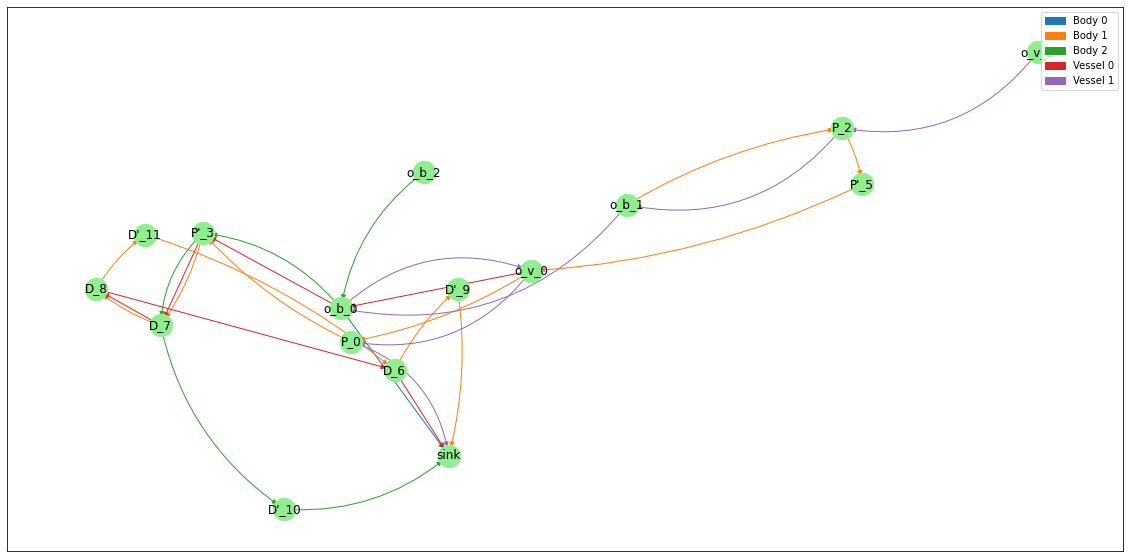

In [44]:
plt.figure(figsize=(20,10))
plot_all_paths()

In [73]:
def _location_paths(index,is_vessels):
    arc_list     = z_v[index]     if is_vessels == 1 else beta_b[index]
    arrival_time = tau_a_v[index] if is_vessels == 1 else tau_a_b[index]  
    path = [arc for arc in arc_list if arc_list[arc].x == 1]
    path_locations = []
    for arc in path:
        dep = nodes_locations[arc[0]]
        arr = nodes_locations[arc[1]]
        if dep != arr and arr != -1:
            path_locations.append((dep,arr))
    return path_locations
    
def plot_paths_locations():
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    G = nx.MultiDiGraph()
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels else n_bodies
        for i in range(n):
            path = _location_paths(i,is_vessels)
            G.add_edges_from(path)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color="#90EE90",node_size = 500)
    nx.draw_networkx_labels(G,pos)
    
    patches = []
    
    for is_vessels in [0,1]:
        n = n_vessels if is_vessels > 0 else n_bodies
        for i in range(n):
            path = _location_paths(i,is_vessels)
            curve = 0.1 if is_vessels == 0 else 0.3
            radius = (-1)**i * curve * i
            style = "arc3,rad=" + str(radius)
            nx.draw_networkx_edges(G,pos,edgelist=path,width = 3,connectionstyle=style, edge_color=colors[n_bodies * is_vessels + i])
            
            label = "Vessel " if is_vessels else "Body "
            label += str(i)
            patches.append(mpatches.Patch(color=colors[n_bodies * is_vessels + i], label=label))
    
    plt.legend(handles=patches)            
    plt.show()        

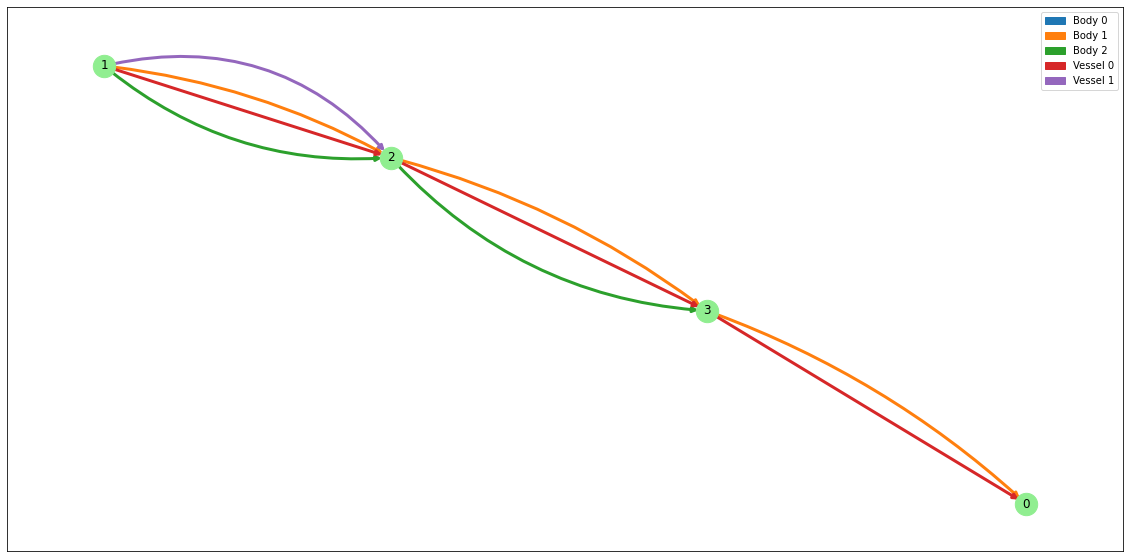

In [75]:
plt.figure(figsize=(20,10))
plot_paths_locations()